In [1]:
import altair as alt
import ibis
import jupyterlab_omnisci

In [2]:
alt.data_transformers.enable('ibis')
alt.renderers.enable("ibis")

RendererRegistry.enable('ibis')

In [3]:
omnisci_cli = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)

In [4]:
t = omnisci_cli.table('flights_donotmodify')

In [5]:
# Let's try and find the city pairs which had the worst average arrival and departure delays
aad = t.arrdelay.mean().name('aad')
add = t.depdelay.mean().name('add')
ct = t.count().name('ct')

filters = [t.dest_city.notnull(), 
           t.origin_city.notnull(),
           t.arrdelay > 0,
           t.depdelay > 0,
           t.carrier_name.notnull(),
           t.flight_year == 2008]

expr = t.filter(filters)\
.group_by([t.dest_city, t.origin_city, t.carrier_name])\
.having([ct > 1000, aad > 30, add > 30])\
.aggregate([aad,add, ct])\
.sort_by([('aad', False),('add', False)])

print(expr.compile())

SELECT *
FROM (
  SELECT "dest_city", "origin_city", "carrier_name", avg("arrdelay") AS aad,
         avg("depdelay") AS add, count(*) AS ct
  FROM flights_donotmodify
  WHERE ("dest_city" IS NOT NULL) AND
        ("origin_city" IS NOT NULL) AND
        ("arrdelay" > 0) AND
        ("depdelay" > 0) AND
        ("carrier_name" IS NOT NULL) AND
        ("flight_year" = 2008)
  GROUP BY dest_city, origin_city, carrier_name
  HAVING count(*) > 1000 AND avg("arrdelay") > 30 AND avg("depdelay") > 30
) t0
ORDER BY "aad" DESC, "add" DESC


In [6]:

ad = t.arrdelay.mean().name('ad')
dd = t.depdelay.mean().name('dd')
flt_bet = t.count().name('fbp')
origin = t.origin_city.name('origin')
dest = t.dest_city.name('dest')

fbp_expr = t.group_by([origin, dest]).aggregate(flt_bet)
#print(fbp_expr.compile())

expr = t\
.group_by(['origin_city','dest_city'])\
.having([ad.notnull(), dd.notnull(), ad > 10, dd > 10])\
.aggregate([ad,dd])

#print(expr.compile())

fc = fbp_expr.view()

#Create a join expr - for all pairs of cities with at least 5000 flights between the pair, 
#find where there were at least an average delay of 10 mins for both arrival and departure
join_expr = fc[(fc.fbp > 5000) ]\
.inner_join(expr,[(fc.origin == expr.origin_city),(fc.dest == expr.dest_city)])[expr, fc.fbp]\
.sort_by([('ad',False),('dd',False)]).limit(100)

#print(join_expr.compile())

chart = alt.Chart(join_expr).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='fbp:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['dd', 'ad', 'fbp'],
    column=['dd', 'ad', 'fbp']
).interactive()

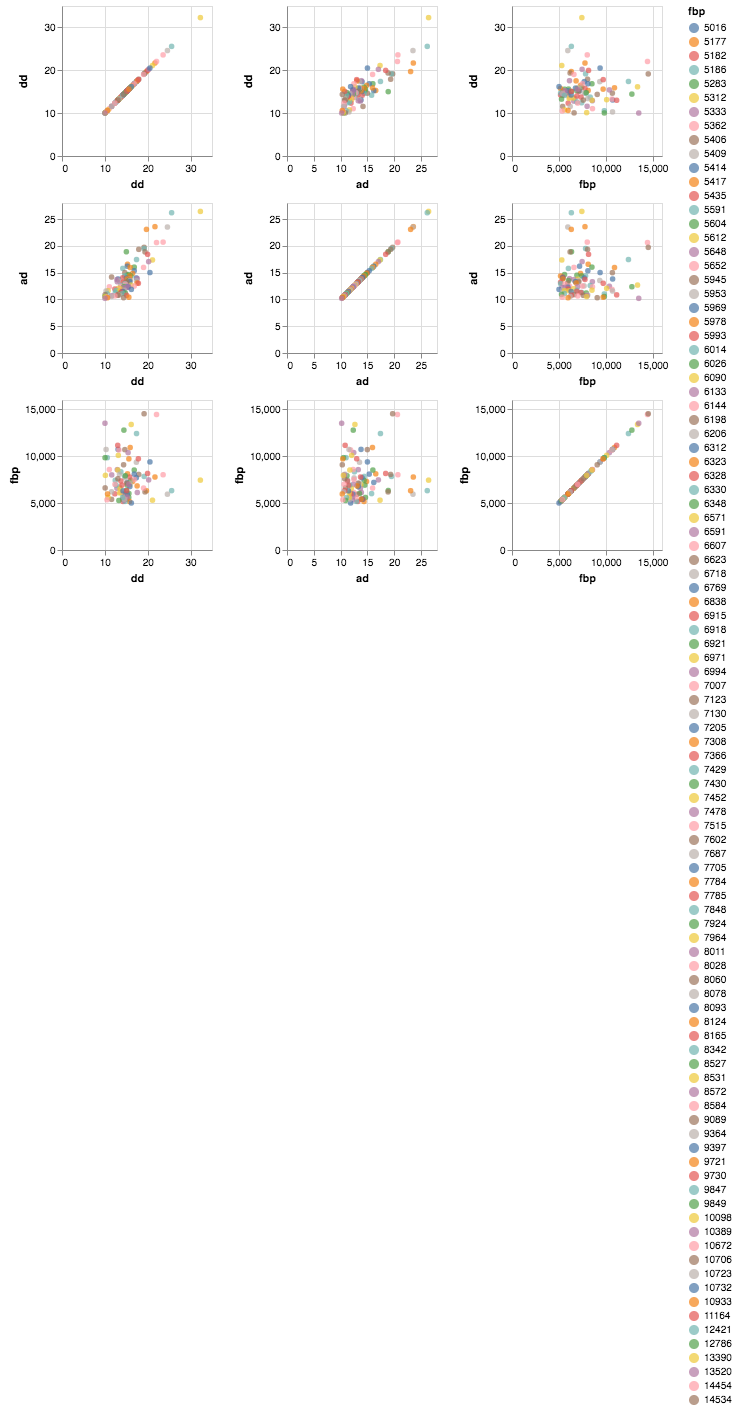

In [7]:
chart

In [13]:
expr.info()

Table rows: 180

Column        Type                   Non-null #
------        ----                   ----------
dest_city     String(nullable=True)  180       
origin_city   String(nullable=True)  180       
carrier_name  String(nullable=True)  180       
aad           float64                180       
add           float64                180       
ct            int64                  180       


In [6]:
hc = alt.Chart(expr).mark_rect().encode(
x = 'dest_city:N',
y = 'origin_city:N',
color = "aad:Q"
).facet(
column="carrier_name:N")

In [7]:
alt.renderers.enable("ibis", compile=False, extract=False, type='vl')
res = hc._repr_mimebundle_(None, None)

In [8]:
res

{'application/vnd.vegalite.v2+json': {'config': {'view': {'width': 400,
    'height': 300}},
  'data': {'url': 'altair-data-8d88b126416577be494ee7e99187968a.json',
   'format': {'type': 'json'}},
  'facet': {'column': {'type': 'nominal', 'field': 'carrier_name'}},
  'spec': {'mark': 'rect',
   'encoding': {'color': {'type': 'quantitative', 'field': 'aad'},
    'x': {'type': 'nominal', 'field': 'dest_city'},
    'y': {'type': 'nominal', 'field': 'origin_city'}}},
  '$schema': 'https://vega.github.io/schema/vega-lite/v3.0.0-rc8.json'},
 'text/plain': '<VegaLite 2 object>\n\nIf you see this message, it means the renderer has not been properly enabled\nfor the frontend that you are using. For more information, see\nhttps://altair-viz.github.io/user_guide/troubleshooting.html\n'}

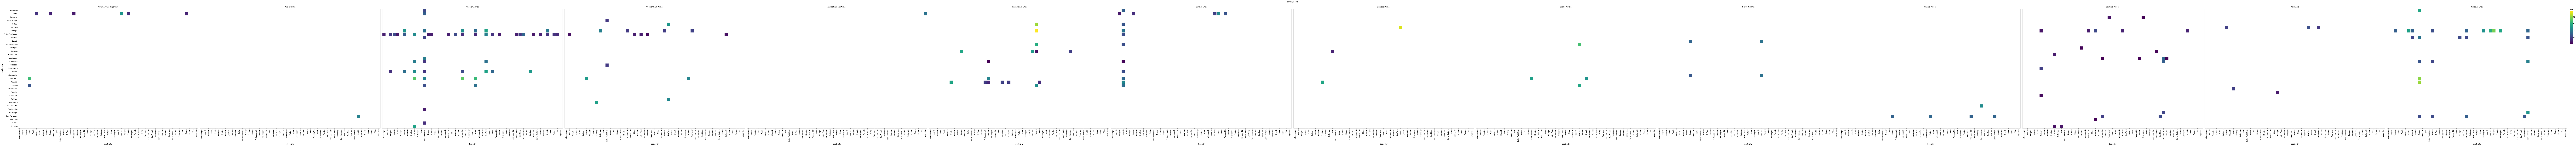

In [9]:
hc

In [12]:
jupyterlab_omnisci.display_chart(hc)

SELECT "origin_city", "dest_city", avg("arrdelay") AS ad,
       avg("depdelay") AS dd
FROM flights_donotmodify
GROUP BY origin_city, dest_city
HAVING avg("arrdelay") IS NOT NULL AND avg("depdelay") IS NOT NULL AND avg("arrdelay") > 10 AND avg("depdelay") > 10

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


SELECT "origin_city", "dest_city", avg("arrdelay") AS ad,
       avg("depdelay") AS dd
FROM flights_donotmodify
GROUP BY origin_city, dest_city
HAVING avg("arrdelay") IS NOT NULL AND avg("depdelay") IS NOT NULL AND avg("arrdelay") > 10 AND avg("depdelay") > 10

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


SELECT "origin_city", "dest_city", avg("arrdelay") AS ad,
       avg("depdelay") AS dd
FROM flights_donotmodify
GROUP BY origin_city, dest_city
HAVING avg("arrdelay") IS NOT NULL AND avg("depdelay") IS NOT NULL AND avg("arrdelay") > 10 AND avg("depdelay") > 10

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
